In [20]:
import pandas as pd
import os 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Get the ISO-Codes
iso = pd.read_csv("ISO/ISO.csv")

In [2]:
# --- NEW: Load DataFrames from CSV ---
print("\nLoading W_ij DataFrames from CSV files...")
W_ij_dataframes = {}
csv_filenames = ['W_1_ij.csv', 'W_2_ij.csv', 'W_3_ij.csv']
for filename in csv_filenames:
    try:
        df_reloaded = pd.read_csv(filename)
        reloaded_df_name = os.path.splitext(filename)[0] # Get original df_name from filename
        W_ij_dataframes[reloaded_df_name] = df_reloaded
        print(f"Loaded {filename}")
    except Exception as e:
        print(f"Error loading {filename}: {e}")


Loading W_ij DataFrames from CSV files...
Loaded W_1_ij.csv
Loaded W_2_ij.csv
Loaded W_3_ij.csv


In [3]:
# Define the desired start and end periods for filtering
start_period = 1989 
end_period = 2020  

print(f"\nFiltering DataFrames for periods between {start_period} and {end_period}...")
# Iterate through the dictionary and filter dataframes in-place
for df_name, df_content in W_ij_dataframes.items():
    if not df_content.empty and 'period' in df_content.columns:
        # Apply the period filter directly to the DataFrame in the dictionary
        original_rows = len(df_content)
        W_ij_dataframes[df_name] = df_content[(df_content['period'] >= start_period) & (df_content['period'] <= end_period)]
        print(f"Filtered {df_name}. Original rows: {original_rows}, Filtered rows: {len(W_ij_dataframes[df_name])}")
    else:
        print(f"Skipping filtering for {df_name}: DataFrame is empty or 'period' column is missing.")



Filtering DataFrames for periods between 1989 and 2020...
Filtered W_1_ij. Original rows: 31911, Filtered rows: 27179
Filtered W_2_ij. Original rows: 12271, Filtered rows: 10586
Filtered W_3_ij. Original rows: 94337, Filtered rows: 78649


In [4]:
#Explanatory Dataframe will be 2002 of Cap 1
TN_t_c = W_ij_dataframes["W_1_ij"][W_ij_dataframes["W_1_ij"]["period"] == 2002]

# Extract relevant columns
edges = TN_t_c[['reporterISO', 'partnerISO', 'W_ij']]

# Get unique country list and index mapping
countries = sorted(list(set(edges['reporterISO']).union(edges['partnerISO'])))
country_index = {country: i for i, country in enumerate(countries)}
n = len(countries)

print(f"Number of countries (N): {n}")
print(f"Country mapping: {country_index}")

Number of countries (N): 131
Country mapping: {'ARE': 0, 'ARG': 1, 'ARM': 2, 'ASM': 3, 'AUS': 4, 'AUT': 5, 'BEL': 6, 'BGD': 7, 'BGR': 8, 'BHR': 9, 'BHS': 10, 'BLR': 11, 'BOL': 12, 'BRA': 13, 'BRB': 14, 'BRN': 15, 'BWA': 16, 'CAN': 17, 'CHE': 18, 'CHL': 19, 'CHN': 20, 'CIV': 21, 'CMR': 22, 'COD': 23, 'COL': 24, 'CRI': 25, 'CUB': 26, 'CYP': 27, 'CZE': 28, 'DEU': 29, 'DMA': 30, 'DNK': 31, 'DOM': 32, 'DZA': 33, 'ECU': 34, 'EGY': 35, 'ESP': 36, 'EST': 37, 'ETH': 38, 'FIN': 39, 'FJI': 40, 'FRA': 41, 'GBR': 42, 'GEO': 43, 'GHA': 44, 'GRC': 45, 'GTM': 46, 'GUY': 47, 'HKG': 48, 'HRV': 49, 'HUN': 50, 'IDN': 51, 'IND': 52, 'IRL': 53, 'IRN': 54, 'ISL': 55, 'ISR': 56, 'ITA': 57, 'JAM': 58, 'JOR': 59, 'JPN': 60, 'KAZ': 61, 'KEN': 62, 'KGZ': 63, 'KNA': 64, 'KOR': 65, 'LBN': 66, 'LKA': 67, 'LTU': 68, 'LUX': 69, 'LVA': 70, 'MAR': 71, 'MDA': 72, 'MDV': 73, 'MEX': 74, 'MKD': 75, 'MLT': 76, 'MNG': 77, 'MOZ': 78, 'MUS': 79, 'MWI': 80, 'MYS': 81, 'MYT': 82, 'NAM': 83, 'NCL': 84, 'NER': 85, 'NGA': 86, 'NIC':

In [5]:
# Initialize weighted adjacency matrix W
# W[i, j] = weight from i to j (i.e., row i is source, col j is destination)
W = np.zeros((n, n))

# Populate W[i, j] = weight from i to j
for index, row in edges.iterrows():
    i = country_index[row['reporterISO']] # Source index
    j = country_index[row['partnerISO']]  # Destination index
    W[i, j] += row['W_ij']


#For seeing the entire matrix uncomment the next line - not everything is a zero:
#np.set_printoptions(threshold=n*n)
print("\nWeighted Adjacency Matrix W (W[i,j] = link from i to j):")
print(W)


Weighted Adjacency Matrix W (W[i,j] = link from i to j):
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [6]:
# Calculate row sums (sum of outgoing link weights from each node i)
row_sums = W.sum(axis=1)

# Handle dangling nodes (nodes with no outgoing links)
# For PageRank, if a node has no outgoing links (row_sum is 0),
# we treat it as if it links to every other node with equal probability.
# This prevents it from being a 'sink' that absorbs all PageRank.
# If a row_sum is 0, we'll replace it with a 1 (or any non-zero value) for division,
# but then ensure the corresponding row in P_row_stochastic is 1/n.
dangling_nodes_mask = (row_sums == 0)
num_dangling_nodes = np.sum(dangling_nodes_mask)
print(f"\nNumber of dangling nodes: {num_dangling_nodes}")


Number of dangling nodes: 8


In [7]:
# Create the transition probability matrix M 
# M[i, j] = P(j | i) = probability of moving from i to j
# This matrix will be ROW-STOCHASTIC (rows sum to 1)
# For non-dangling nodes: M_ij = W_ij / sum_k(W_ik)
# For dangling nodes: M_ij = 1/n (they jump to any page)

# Create a matrix where each element is W_ij / (sum of outgoing links from i)
# For rows with sum 0, it will result in NaN/Inf. We handle this below.
M_row_stochastic = np.divide(W, row_sums[:, np.newaxis], where=row_sums[:, np.newaxis] != 0)

# Explicitly handle dangling nodes: set their rows to 1/n
# This is crucial for PageRank's teleportation model and preventing sinks.
if num_dangling_nodes > 0:
    # Set the rows corresponding to dangling nodes to all zeros first
    M_row_stochastic[dangling_nodes_mask, :] = 0
    # Then add the teleportation jump for these nodes
    M_row_stochastic[dangling_nodes_mask, :] = 1.0 / n # They jump to any page with 1/n probability # In OG example this was 0.0076 percent

print("\nRow-Stochastic Transition Matrix M (M[i,j] = P(j|i) from i to j):")
print(M_row_stochastic)
print("Row sums of M (should be 1 or close to 1):", M_row_stochastic.sum(axis=1))


Row-Stochastic Transition Matrix M (M[i,j] = P(j|i) from i to j):
[[0.00763359 0.00763359 0.00763359 ... 0.00763359 0.00763359 0.00763359]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.00763359 0.00763359 0.00763359 ... 0.00763359 0.00763359 0.00763359]]
Row sums of M (should be 1 or close to 1): [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [8]:
# Transpose to get the COLUMN-STOCHASTIC matrix P for PageRank formula
# P[j, i] = probability of moving from i to j. Columns of P sum to 1.
P = M_row_stochastic.T

print("\nColumn-Stochastic Transition Matrix P (P[j,i] = P(j|i) from i to j):")
print(P)
print("Column sums of P (should be 1 or close to 1):", P.sum(axis=0))


Column-Stochastic Transition Matrix P (P[j,i] = P(j|i) from i to j):
[[0.00763359 0.         0.         ... 0.         0.         0.00763359]
 [0.00763359 0.         0.         ... 0.         0.         0.00763359]
 [0.00763359 0.         0.         ... 0.         0.         0.00763359]
 ...
 [0.00763359 0.         0.         ... 0.         0.         0.00763359]
 [0.00763359 0.         0.         ... 0.         0.         0.00763359]
 [0.00763359 0.         0.         ... 0.         0.         0.00763359]]
Column sums of P (should be 1 or close to 1): [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [9]:
# Damping factor and teleportation vector
alpha = 0.85
v = np.ones(n) / n # Uniform teleportation vector

print(f"\nDamping factor (alpha): {alpha}")
print(f"Teleportation vector (v): {v}")


Damping factor (alpha): 0.85
Teleportation vector (v): [0.00763359 0.00763359 0.00763359 0.00763359 0.00763359 0.00763359
 0.00763359 0.00763359 0.00763359 0.00763359 0.00763359 0.00763359
 0.00763359 0.00763359 0.00763359 0.00763359 0.00763359 0.00763359
 0.00763359 0.00763359 0.00763359 0.00763359 0.00763359 0.00763359
 0.00763359 0.00763359 0.00763359 0.00763359 0.00763359 0.00763359
 0.00763359 0.00763359 0.00763359 0.00763359 0.00763359 0.00763359
 0.00763359 0.00763359 0.00763359 0.00763359 0.00763359 0.00763359
 0.00763359 0.00763359 0.00763359 0.00763359 0.00763359 0.00763359
 0.00763359 0.00763359 0.00763359 0.00763359 0.00763359 0.00763359
 0.00763359 0.00763359 0.00763359 0.00763359 0.00763359 0.00763359
 0.00763359 0.00763359 0.00763359 0.00763359 0.00763359 0.00763359
 0.00763359 0.00763359 0.00763359 0.00763359 0.00763359 0.00763359
 0.00763359 0.00763359 0.00763359 0.00763359 0.00763359 0.00763359
 0.00763359 0.00763359 0.00763359 0.00763359 0.00763359 0.00763359
 0.007

In [10]:
# Power iteration initialization
r = np.ones(n) / n # Initial PageRank vector, uniform distribution
epsilon = 1e-8      # Convergence threshold
delta = 1.0         # Initial change
iteration = 0       # Iteration counter

print(f"\nInitial PageRank vector (r): {r}")
print(f"Convergence epsilon: {epsilon}")


Initial PageRank vector (r): [0.00763359 0.00763359 0.00763359 0.00763359 0.00763359 0.00763359
 0.00763359 0.00763359 0.00763359 0.00763359 0.00763359 0.00763359
 0.00763359 0.00763359 0.00763359 0.00763359 0.00763359 0.00763359
 0.00763359 0.00763359 0.00763359 0.00763359 0.00763359 0.00763359
 0.00763359 0.00763359 0.00763359 0.00763359 0.00763359 0.00763359
 0.00763359 0.00763359 0.00763359 0.00763359 0.00763359 0.00763359
 0.00763359 0.00763359 0.00763359 0.00763359 0.00763359 0.00763359
 0.00763359 0.00763359 0.00763359 0.00763359 0.00763359 0.00763359
 0.00763359 0.00763359 0.00763359 0.00763359 0.00763359 0.00763359
 0.00763359 0.00763359 0.00763359 0.00763359 0.00763359 0.00763359
 0.00763359 0.00763359 0.00763359 0.00763359 0.00763359 0.00763359
 0.00763359 0.00763359 0.00763359 0.00763359 0.00763359 0.00763359
 0.00763359 0.00763359 0.00763359 0.00763359 0.00763359 0.00763359
 0.00763359 0.00763359 0.00763359 0.00763359 0.00763359 0.00763359
 0.00763359 0.00763359 0.0076335

In [11]:
# Power iteration loop
while delta > epsilon:
    # PageRank formula: r_new = alpha * P @ r + (1 - alpha) * v
    r_new = alpha * P @ r + (1 - alpha) * v
    delta = np.linalg.norm(r_new - r, 1) # L1 norm for convergence check
    r = r_new                           # Update r for next iteration
    iteration += 1

print(f"\nAlgorithm converged in {iteration} iterations.")
print("Final PageRank vector (r):", r)


Algorithm converged in 26 iterations.
Final PageRank vector (r): [0.00158474 0.00331281 0.00122127 0.0012541  0.00389199 0.01503559
 0.00761063 0.00122127 0.00123578 0.00122127 0.00122127 0.00122127
 0.00122127 0.00125268 0.00122131 0.00122127 0.00122127 0.00240566
 0.00664973 0.00201634 0.2677434  0.00122127 0.00122127 0.00138234
 0.00122127 0.00122127 0.00134635 0.00128698 0.00142394 0.02641776
 0.00122127 0.00140205 0.00122127 0.00122127 0.00122127 0.00122127
 0.00229224 0.01552659 0.00122127 0.00125517 0.00122127 0.08362226
 0.03464063 0.00122127 0.00122127 0.00122127 0.00122127 0.00122127
 0.01936556 0.00122127 0.00123275 0.00122953 0.01038033 0.00220303
 0.00122127 0.00122127 0.00196945 0.0054969  0.00122127 0.00122127
 0.18098876 0.0093433  0.00138176 0.00238401 0.00122127 0.00497219
 0.00150865 0.00122129 0.00224112 0.00122127 0.00122127 0.00122127
 0.00122127 0.00122127 0.00265804 0.00122127 0.00122127 0.00130519
 0.00122127 0.00122127 0.00122127 0.0014276  0.00122127 0.00122

In [12]:
# Create DataFrame of final PageRank scores
pagerank_df = pd.DataFrame({
    'Country': countries,
    'PageRank': r
}).sort_values(by='PageRank', ascending=False).reset_index(drop=True)

print("\nTop 10 PageRank scores:")
print(pagerank_df.head(10))


Top 10 PageRank scores:
  Country  PageRank
0     CHN  0.267743
1     JPN  0.180989
2     USA  0.099711
3     FRA  0.083622
4     GBR  0.034641
5     DEU  0.026418
6     RUS  0.023489
7     HKG  0.019366
8     EST  0.015527
9     AUT  0.015036


In [15]:
all_pagerank_results = {}


for df_name, current_tn_df_full in W_ij_dataframes.items():
    print(f"Processing DataFrame: {df_name}")
    
    # Dictionary to store results for the current dataframe, by period
    # Period keys will be integers here
    current_df_pagerank = {}

    # Loop through unique periods in the current dataframe
    for t in sorted(current_tn_df_full['period'].unique()):
        print(f"  Processing Period: {t}")
        
        # Filter the dataframe for the current period
        TN_t_c = current_tn_df_full[current_tn_df_full['period'] == t]

        # Extract relevant columns
        edges = TN_t_c[['reporterISO', 'partnerISO', 'W_ij']]

        # Get unique country list and index mapping
        countries = sorted(list(set(edges['reporterISO']).union(edges['partnerISO'])))
        country_index = {country: i for i, country in enumerate(countries)}
        n = len(countries)

        # Skip if no edges exist for the period
        if n == 0:
            print(f"    No edges found for period {t}. Skipping PageRank calculation.")
            continue
            
        # Initialize weighted adjacency matrix W
        # W[i, j] = weight from i to j (i.e., row i is source, col j is destination)
        W = np.zeros((n, n))

        # Populate W[i, j] = weight from i to j
        for index, row in edges.iterrows():
            i = country_index[row['reporterISO']] # Source index
            j = country_index[row['partnerISO']]  # Destination index
            W[i, j] += row['W_ij']

        # Calculate row sums (sum of outgoing link weights from each node i)
        row_sums = W.sum(axis=1)

        # Handle dangling nodes (nodes with no outgoing links)
        dangling_nodes_mask = (row_sums == 0)
        num_dangling_nodes = np.sum(dangling_nodes_mask)

        # Create the transition probability matrix M (often denoted P' or A_norm)
        # M[i, j] = P(j | i) = probability of moving from i to j
        # This matrix will be ROW-STOCHASTIC (rows sum to 1)
        # For non-dangling nodes: M_ij = W_ij / sum_k(W_ik)
        # For dangling nodes: M_ij = 1/n (they jump to any page)
        
        # Create a matrix where each element is W_ij / (sum of outgoing links from i)
        # For rows with sum 0, it will result in NaN/Inf. We handle this below.
        M_row_stochastic = np.divide(W, row_sums[:, np.newaxis], where=row_sums[:, np.newaxis] != 0)

        # Explicitly handle dangling nodes: set their rows to 1/n
        if num_dangling_nodes > 0:
            M_row_stochastic[dangling_nodes_mask, :] = 1.0 / n # They jump to any page with 1/n probability

        # Transpose to get the COLUMN-STOCHASTIC matrix P for PageRank formula
        # P[j, i] = probability of moving from i to j. Columns of P sum to 1.
        P = M_row_stochastic.T

        # Damping factor and teleportation vector
        alpha = 0.85
        v = np.ones(n) / n # Uniform teleportation vector

        # Power iteration initialization
        r = np.ones(n) / n # Initial PageRank vector, uniform distribution
        epsilon = 1e-8      # Convergence threshold
        delta = 1.0         # Initial change
        iteration = 0       # Iteration counter

        # Power iteration loop
        max_iterations = 1000 # Add a safeguard for non-convergence
        while delta > epsilon and iteration < max_iterations:
            # PageRank formula: r_new = alpha * P @ r + (1 - alpha) * v
            r_new = alpha * P @ r + (1 - alpha) * v
            delta = np.linalg.norm(r_new - r, 1) # L1 norm for convergence check
            r = r_new                           # Update r for next iteration
            iteration += 1
        
        if iteration >= max_iterations:
            print(f"    Warning: PageRank did not converge for period {t} after {max_iterations} iterations.")


        # Create DataFrame of final PageRank scores
        pagerank_df = pd.DataFrame({
            'Country': countries,
            'PageRank': r
        }).sort_values(by='PageRank', ascending=False).reset_index(drop=True)
        
        # Store the results for the current period using the integer 't' as the key
        current_df_pagerank[t] = pagerank_df
    
    # Store the results for the current dataframe
    all_pagerank_results[df_name] = current_df_pagerank

Processing DataFrame: W_1_ij
  Processing Period: 1989
  Processing Period: 1990
  Processing Period: 1991
  Processing Period: 1992
  Processing Period: 1993
  Processing Period: 1994
  Processing Period: 1995
  Processing Period: 1996
  Processing Period: 1997
  Processing Period: 1998
  Processing Period: 1999
  Processing Period: 2000
  Processing Period: 2001
  Processing Period: 2002
  Processing Period: 2003
  Processing Period: 2004
  Processing Period: 2005
  Processing Period: 2006
  Processing Period: 2007
  Processing Period: 2008
  Processing Period: 2009
  Processing Period: 2010
  Processing Period: 2011
  Processing Period: 2012
  Processing Period: 2013
  Processing Period: 2014
  Processing Period: 2015
  Processing Period: 2016
  Processing Period: 2017
  Processing Period: 2018
  Processing Period: 2019
  Processing Period: 2020
Processing DataFrame: W_2_ij
  Processing Period: 1989
  Processing Period: 1990
  Processing Period: 1991
  Processing Period: 1992
  Proc

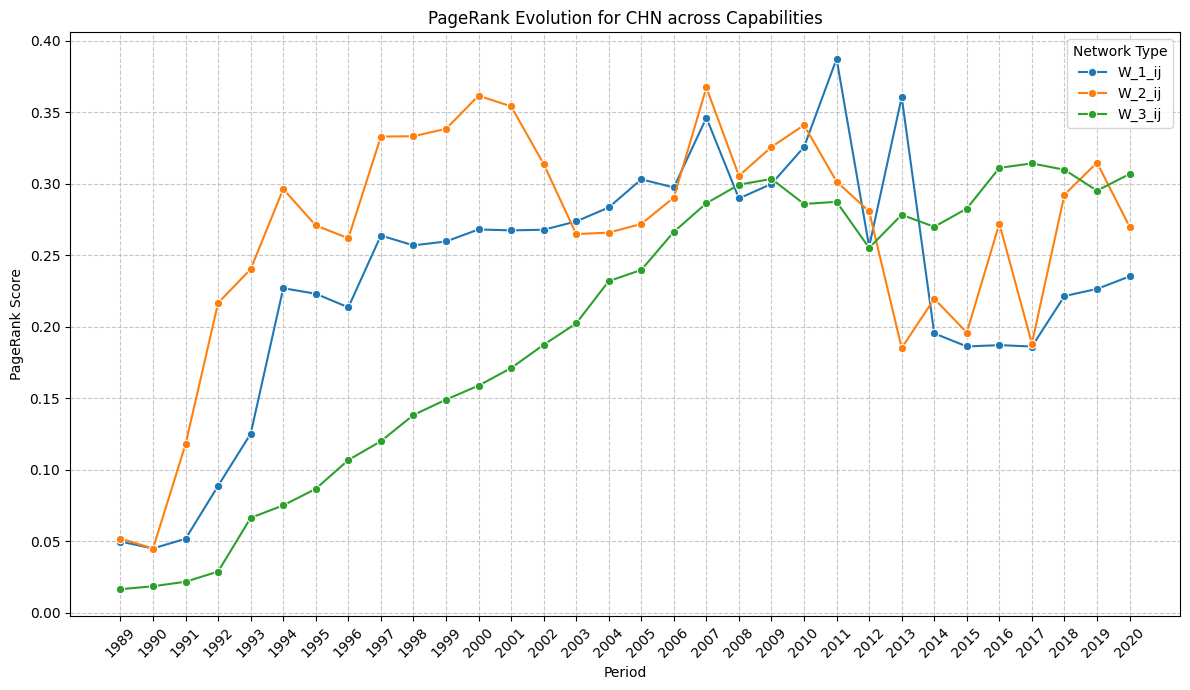

In [30]:
def plot_country_pagerank_evolution(all_pagerank_results, country_iso):
    """
    Visualizes the PageRank evolution of a specific country across different
    W_ij dataframes and over various periods.

    Args:
        all_pagerank_results (dict): A dictionary containing PageRank results.
                                     Expected structure:
                                     {df_name: {period: pd.DataFrame(Country, PageRank)}}
        country_iso (str): The ISO code of the country to visualize (e.g., 'CHN').
    """

    plot_data = []

    for df_name, periods_data in all_pagerank_results.items():
        for period, pagerank_df in periods_data.items():
            # Find the PageRank for the specified country in this period's dataframe
            country_pr_row = pagerank_df[pagerank_df['Country'] == country_iso]
            
            if not country_pr_row.empty:
                pagerank_value = country_pr_row['PageRank'].iloc[0]
                plot_data.append({
                    'Period': period,
                    'DataFrame': df_name,
                    'PageRank': pagerank_value
                })
            else:
                # If the country is not found in this period's network, add a NaN entry
                # This will create a break in the line for that DataFrame
                plot_data.append({
                    'Period': period,
                    'DataFrame': df_name,
                    'PageRank': np.nan
                })
    
    # Convert the list of dictionaries to a DataFrame for easy plotting
    df_plot = pd.DataFrame(plot_data)

    # Sort by period to ensure lines are drawn correctly
    df_plot = df_plot.sort_values(by=['DataFrame', 'Period'])

    if df_plot.empty:
        print(f"No PageRank data found for country '{country_iso}'. Cannot generate plot.")
        return

    plt.figure(figsize=(12, 7))
    sns.lineplot(data=df_plot, x='Period', y='PageRank', hue='DataFrame', marker='o')

    plt.title(f'PageRank Evolution for {country_iso} across Capabilities')
    plt.xlabel('Period')
    plt.ylabel('PageRank Score')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(title='Network Type')
    plt.xticks(df_plot['Period'].unique(), rotation = 45) # Ensure all periods are marked on x-axis
    plt.tight_layout()
    plt.show()

# Specify the country you want to visualize
target_country = 'CHN'

# Call the function to generate the plot
plot_country_pagerank_evolution(all_pagerank_results, target_country)